optics_tools is a small package for doing basic calculations on satellite optical systems

In [1]:
import optics_tools as ot
from optics_tools import const as const

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Have some functions for perfoming conversions, these are prepended with `conv`, use tab completion to see these functions

In [3]:
print(ot.conv_celcius_to_kelvin.__doc__)


    Convert Celcius to Kelvin

    Returns
    -------
    double : Kelvin
    


In [4]:
ot.conv_celcius_to_kelvin(0)

273.15

And also functions for doing calculations, prepended with `calc`

In [5]:
print(ot.calc_gsd_cross.__doc__)


    ground sample distance (gsd) is the distance between pixel centers measured
    on the ground.
    https://en.wikipedia.org/wiki/Ground_sample_distance

    Returns
    -------
    double : meters per pixel
    


Each input is defined in the module docstring, which is too long to print here

### Exploring relationships
Lets explore how some important imager performance metrics depend on the detector and mission parameters. We use dictionaries to group variables together, being careful to use the variables defined in `optics_tools` docstring. Note that all variables have SI units. Here the detector and the satellite/imager are seperate entities, but the imager is considered part of the satellite. Values that are calculated are put in the `calculated` dict for clarity.

`GSD` = ground sampling distance, smaller GSD is considered better

In [6]:
detector = {}
detector['pixel_pitch'] = 25e-6

In [7]:
satellite = {}
satellite['altitude'] = 600e3
satellite['focal_length'] = 375e-3

In [8]:
calculated = {}
calculated['gsd_cross'] = ot.calc_gsd_cross(altitude=satellite['altitude'], 
                                            focal_length=satellite['focal_length'], 
                                            pixel_dim_cross=detector['pixel_pitch'])

In [9]:
print(calculated)

{'gsd_cross': 40.0}


Lets see how ground sampling distance varies with pixel pitch for fixed altitude and focal length

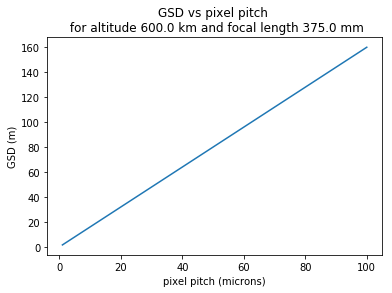

In [10]:
pixels_test = np.linspace(1e-6, 100e-6)

gsd_calculated = ot.calc_gsd_cross(altitude=satellite['altitude'], 
                                            focal_length=satellite['focal_length'], 
                                            pixel_dim_cross=pixels_test)

plt.plot(pixels_test * 1e6, gsd_calculated)
plt.title('GSD vs pixel pitch \n for altitude {} km and focal length {} mm'.format(
    satellite['altitude']/1e3, satellite['focal_length']*1e3))
plt.ylabel('GSD (m)')
plt.xlabel('pixel pitch (microns)');

We see the linear increase in GSD with pixel pitch/size as GSD is just the projection of the pixel on the Earth. 

Theres are few other simple relations to keep in mind:
* Swath is linear in GSD, altitude and number of pixels
* Camera input power is linear with the area of the camera aperture, but inversely proportional to the square of the altitude
* Camera field of view (FOV) is proportinal to the size of the detector, and inversely proportional to the focal length
* For a fixed FOV, resolution/GSD get worse with increasing altitude

I want a tool to help guide imager/mission spec based on a selected detector, and the resultant GSD, swath and SNR. Assume perfect optical system with no losses. Can I assume integration_time hardly changes with altitude?

In [11]:
altitude = 800e3
integration_time = 20.0/(ot.calc_velocity_ground_track(ot.calc_earth_orbital_period(altitude)))
print(integration_time*1000) # ms

3.0205363249910615


Yes integration time hardly changes, always around 3 ms. Therefore for SNR just take ratio of electrons generated by input power to noise current

In [14]:
def calc_mission_performance(aperture_diameter=0.05, 
                             focal_length=375e-3, 
                             pixel_pitch=20e-6, 
                             pixels_cross=2048, 
                             noise_current=1.5e6):
    """Convenience for calculating important mission performance metrics."""
    inputs = {} # In alphabetical order

    inputs['altitude'] = 600e3
    inputs['aperture_diameter'] = aperture_diameter
    inputs['focal_length'] = focal_length
    inputs['noise_current'] = noise_current
    inputs['pixel_pitch'] = pixel_pitch
    inputs['pixels_cross'] = pixels_cross
    inputs['quantum_efficiency'] = 0.7
    inputs['radiance_integrated'] = 1.0 # TBD
    inputs['wavelength'] = 1000e-9

    outputs = {} # Keep the ordering
    outputs['f_number'] = ot.calc_f_number(inputs['aperture_diameter'], inputs['focal_length'])
    outputs['gsd_cross'] = ot.calc_gsd_cross(inputs['altitude'], inputs['focal_length'], inputs['pixel_pitch'])
    outputs['swath_at_nadir_cross'] = ot.calc_swath_at_nadir_cross(outputs['gsd_cross'], inputs['pixels_cross'])
    outputs['radiated_power_nadir'] = ot.calc_radiated_power_nadir(inputs['radiance_integrated'], outputs['gsd_cross'], outputs['gsd_cross'])
    outputs['camera_input_power'] = ot.calc_camera_input_power(inputs['altitude'], inputs['aperture_diameter'], outputs['radiated_power_nadir'])
    outputs['integration_time'] = outputs['gsd_cross']/(ot.calc_velocity_ground_track(ot.calc_earth_orbital_period(inputs['altitude'])))
    outputs['energy_available'] = ot.calc_energy_per_integration(outputs['camera_input_power'], outputs['integration_time'])
    outputs['photons_available'] = ot.calc_photons_from_energy(outputs['energy_available'], inputs['wavelength'])
    outputs['signal_electrons'] = ot.calc_electrons_from_photons(outputs['photons_available'], inputs['quantum_efficiency'])

    outputs['SNR'] = outputs['signal_electrons']/ (inputs['noise_current'] * outputs['integration_time'])
    
    return int(outputs['gsd_cross']), int(outputs['swath_at_nadir_cross']/1e3), int(outputs['SNR']), outputs['f_number']

In [18]:
APERTURE_DIAMETER = 0.075
CAMERAS = 6
FOCAL_LENGTH = 375e-3
PIXEL_PITCH = 12.5e-6
PIXELS_CROSS = 1280 # Only affects swath
NOISE_CURRENT = 0.2 * 1.5e6

GSD, SWATH, SNR, F_NUM = calc_mission_performance(APERTURE_DIAMETER, FOCAL_LENGTH, PIXEL_PITCH, PIXELS_CROSS, NOISE_CURRENT)
print("GSD:{}m SWATH:{}km SNR:{} F_NUM:{}".format(GSD, SWATH * CAMERAS, SNR, F_NUM))

GSD:20m SWATH:150km SNR:57 F_NUM:5.0


If we need more swath, just get a detector with more pixels or increase number of cameras